### Import

In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

import json
import multiprocessing
import surprise
import gzip

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

from scipy import sparse
from surprise import accuracy, Dataset, KNNBasic, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

import datetime
import random

## 1.0 Apertura beeradvocate 

In [42]:
# Conversione da gz a csv

def parse(path):
    g =gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
def getDF(path):
    i=0
    df={}
    for d in parse(path):
        df[i]=d
        i+=1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/Users/dvettore/Desktop/beeradvocate.json.gz')

df.to_csv('/Users/dvettore/Desktop/beeradvocate.csv', index=False)

In [4]:
# Si può ora aprire il file csv 

df = pd.read_csv('/Users/dvettore/Desktop/beeradvocate.csv',sep=',', low_memory = False)

In [7]:
# Rimozione valori nulli, rating duplicati, rating pari a 0, conversione rating a int8

df = df.dropna(subset=['beer/name','review/overall','review/profileName','beer/style' ], how='all')
df = df.drop_duplicates(['review/profileName','beer/name'], keep= 'last')
df = df[df['review/overall'] != 0]
df['review/overall'] = df['review/overall'].astype('int8')

## 1.1 Analisi esplorativa e riduzione dataset

In [9]:
print(df.groupby('review/overall')['review/overall'].count())
print(df.dtypes)
print(df.shape)
print(df.sample(5))

review/overall
1     23704
2     95638
3    460991
4    891872
5     89520
Name: review/overall, dtype: int64
beer/name              object
beer/beerId             int64
beer/brewerId           int64
beer/ABV              float64
beer/style             object
review/appearance     float64
review/aroma          float64
review/palate         float64
review/taste          float64
review/overall           int8
review/time             int64
review/profileName     object
review/text            object
dtype: object
(1561725, 13)
                             beer/name  beer/beerId  beer/brewerId  beer/ABV  \
1436146  Old Chub - Scottish Style Ale        14712           2681       8.0   
1287341                      Budweiser           65             29       5.0   
1036602              Petrus Winterbier         2481            718       6.5   
219057             Yeti Imperial Stout        12013            158       9.5   
83137    Sierra Nevada Celebration Ale         1904            140      

                                  count  mean rating
beer/style                                          
American Wild Ale                 17622     4.091335
Gueuze                             5982     4.085172
Quadrupel (Quad)                  17980     4.071385
Lambic - Unblended                 1109     4.048693
American Double / Imperial Stout  49838     4.027860
Russian Imperial Stout            52972     4.022191
Weizenbock                         9336     4.006427
American Double / Imperial IPA    84462     3.994672
Flanders Red Ale                   6606     3.991901
Keller Bier / Zwickel Bier         2555     3.982387
                        count  mean rating
beer/style                                
Kvass                     295     3.355932
Euro Pale Lager         17783     3.202159
Japanese Rice Lager      1535     3.121824
Chile Beer               2281     3.113108
American Adjunct Lager  30293     2.998548
Happoshu                  241     2.914938
Euro Strong Lager   

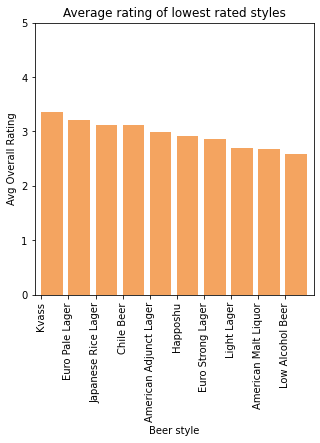

In [317]:
# 1. Voto medio rispetto al beer style 

count_df = df.groupby('beer/style')['review/overall'].count().sort_values(ascending=False)
mean_df = df.groupby('beer/style')['review/overall'].mean()

merged_df = pd.merge(count_df, mean_df, left_index=True, right_index=True)
merged_df.columns = ['count','mean rating']
merged_df_sorted = merged_df.sort_values(by='mean rating', ascending=False)

print(merged_df_sorted.head(10))
print(merged_df_sorted.tail(10))

plt.figure(figsize=(5, 5))
merged_df_sorted['mean rating'].tail(10).plot(kind='bar', width=0.8, color='sandybrown', align='edge')
plt.ylim(0,5)
plt.xlabel('Beer style')
plt.ylabel('Avg Overall Rating')
plt.title('Average rating of lowest rated styles')
plt.xticks(rotation=90)
plt.show()

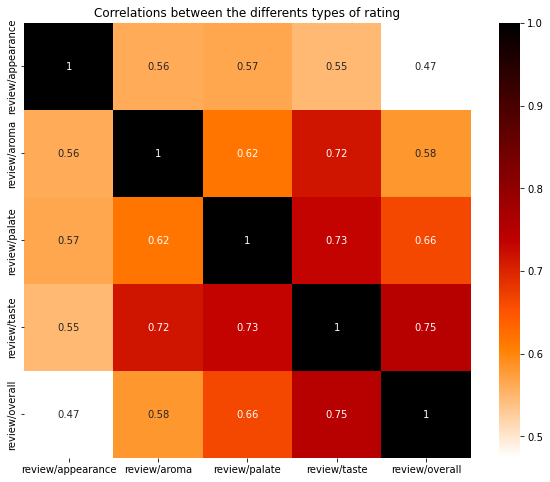

In [10]:
# 2. Correlazione tra diverse tipologie di ratings

correlation_matrix = df[['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='gist_heat_r')
plt.title('Correlations between the differents types of rating')
plt.show()

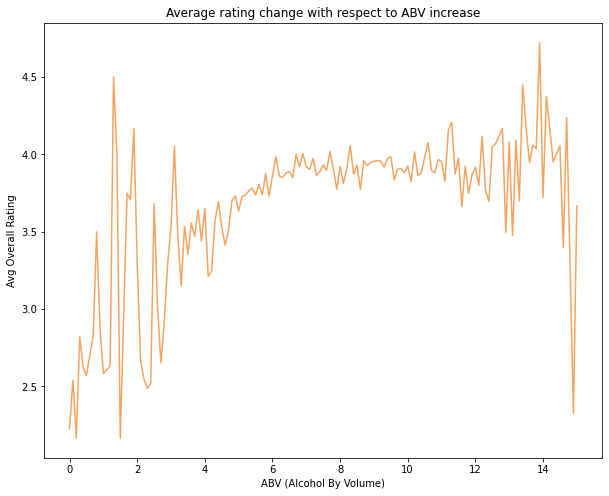

In [329]:
# 3. Overall rating rispetto al volume alcolico

df['ABVstandardized'] = round(df['beer/ABV'],1)
df['ABVstandardized'].loc[df['ABVstandardized']>15] = 15

mean_rating_by_abv = df.groupby('ABVstandardized')['review/overall'].mean()

plt.figure(figsize=(10, 8))
plt.plot(mean_rating_by_abv.index, mean_rating_by_abv.values, color='sandybrown')
plt.xlabel('ABV (Alcohol By Volume)')
plt.ylabel('Avg Overall Rating')
plt.title('Average rating change with respect to ABV increase')
plt.show()

In [11]:
# Analisi utente che recensisce di più (andrebbe eseguito dopo aver creato smallDf ma per ordine l'ho messo insieme all'analisi esplorativa)

print(smallDf.groupby(['user_name']).count()['rating'].idxmax())
smallDf.loc[smallDf['user_name']=='BuckeyeNation'].sample(5)

BuckeyeNation


,item_name,user_name,rating
563371,Two Jokers Double-Wit,BuckeyeNation,4
819156,Saranac ESB,BuckeyeNation,3
987296,Grozet Gooseberry & Wheat Ale,BuckeyeNation,4
858132,Centennial Single Hop IPA,BuckeyeNation,4
1534755,Cuvée Van De Keizer Blauw (Blue),BuckeyeNation,4


In [363]:
count_u = df.loc[df['review/profileName']=='BuckeyeNation'].groupby('beer/style')['review/overall'].count()
mean_u = df.loc[df['review/profileName']=='BuckeyeNation'].groupby('beer/style')['review/overall'].mean()

merged_df = pd.merge(count_u, mean_u, left_index=True, right_index=True)
merged_df.columns = ['count','mean rating']
merged_df_sorted = merged_df.sort_values(by='mean rating', ascending=False)
#merged_df_sorted

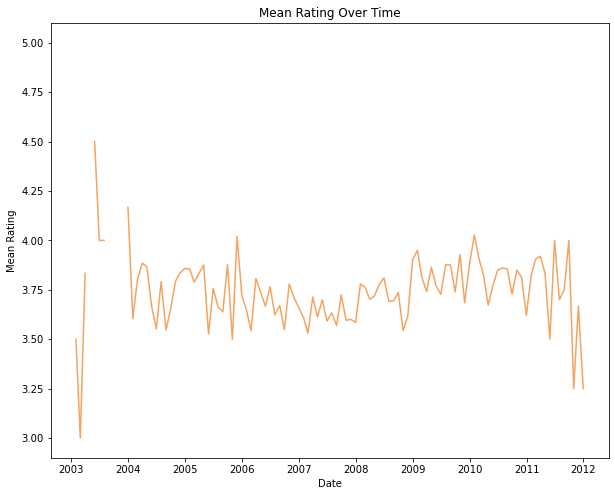

In [361]:
def convert_timestamp(timestamp):
    date = datetime.datetime.fromtimestamp(timestamp).strftime('%d/%m/%y')
    return date

df['date'] = df['review/time'].apply(convert_timestamp)

df['date'] = pd.to_datetime(df['date'])
df['review/overall'] = df['review/overall'].astype(float)

mean_rating_by_time = df.loc[df['review/profileName'] == 'BuckeyeNation'].set_index('date').resample('M')['review/overall'].mean()

plt.figure(figsize=(10, 8))
plt.plot(mean_rating_by_time.index, mean_rating_by_time.values, color='sandybrown')
plt.xlabel('Date')
plt.ylabel('Mean Rating')
plt.title('Mean Rating Over Time')
plt.show()

In [ ]:
# Eliminazione colonne

df = df[['beer/name','review/profileName','review/overall']]
df = df.rename(columns={'beer/name':"item_name",'review/profileName':"user_name",'review/overall':"rating"})

In [12]:
# Osservazione matrice di ratings completa

uniqueUs = df['user_name'].unique()
uniqueIt = df['item_name'].unique()
size = len(uniqueUs)*len(uniqueIt)
print("shape matrice: ",len(uniqueUs),'-',len(uniqueIt), "| size matrice: ", len(uniqueUs)*len(uniqueIt), "| ratings presenti: ", len(df), "| percentuale: " , round(((len(df)/(len(uniqueUs)*len(uniqueIt)))*100),3),"%")

shape matrice:  33387 - 56856 | size matrice:  1898251272 | ratings presenti:  1561398 | percentuale:  0.082 %


In [319]:
100-0.082

99.918

In [18]:
# Riduzione matrice di ratings

topIt = df.item_name.value_counts().head(4000).index         #riduzione items    
smallDf = df[df.item_name.isin(topIt)]

topUs = smallDf.user_name.value_counts().head(4000).index    #riduzione users  
smallDf = smallDf[smallDf.user_name.isin(topUs)]

print(df.shape, " --> " , smallDf.shape)

(1561398, 3)  -->  (1000360, 3)


In [20]:
# Osservazione matrice di ratings ridotta 

uniqueUs = smallDf['user_name'].unique()
uniqueIt = smallDf['item_name'].unique()
print("shape matrice: ",len(uniqueUs),'-',len(uniqueIt), "| size matrice: ", len(uniqueUs)*len(uniqueIt), "| ratings presenti: ", len(smallDf), "| percentuale: " , round(((len(smallDf)/(len(uniqueUs)*len(uniqueIt)))*100),3),"%")

#print(smallDf.groupby('user_name')['user_name'].count().sort_values(ascending=False))
#print(smallDf.groupby('item_name')['item_name'].count().sort_values(ascending=False))

shape matrice:  4000 - 4000 | size matrice:  16000000 | ratings presenti:  1000360 | percentuale:  6.252 %


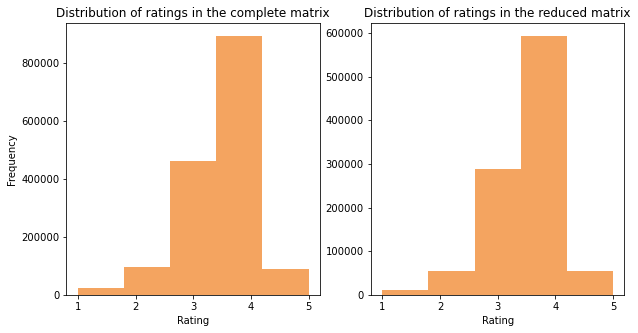

In [21]:
# 1. Variazione frequenza dei rating

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(df['rating'], bins = 5, color ='sandybrown')
axs[0].set_title('Distribution of ratings in the complete matrix')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Rating')

axs[1].hist(smallDf['rating'], bins = 5, color ='sandybrown')
axs[1].set_title('Distribution of ratings in the reduced matrix')
axs[1].set_xlabel('Rating')

plt.show()

In [38]:
# 2. Variazione occorrenze items

describe = pd.concat([df.groupby(['item_name']).count()['rating'].describe(), 
                      smallDf.groupby(['item_name']).count()['rating'].describe()], axis=1)
describe.columns = ['Items ocurrencies in the complete matrix', 'Items ocurrencies in the reduced matrix']
describe

,Items ocurrencies in the complete matrix,Items ocurrencies in the reduced matrix
count,56856.000000,4000.00000
mean,27.462326,250.09000
std,118.684510,265.81839
min,1.000000,46.00000
25%,1.000000,91.00000
50%,3.000000,151.00000
75%,9.000000,292.00000
max,3206.000000,2172.00000


In [5]:
smallDf.groupby(['item_name']).count()['rating'].idxmin()

'Tap Room No. 21 Amber Ale'

In [142]:
smallDf.groupby(['item_name']).count()['rating'].idxmax()

'90 Minute IPA'

In [39]:
# 3. Variazione occorrenze users

describe = pd.concat([df.groupby(['user_name']).count()['rating'].describe(), 
                      smallDf.groupby(['user_name']).count()['rating'].describe()], axis=1)
describe.columns = ['Users ocurrencies in the complete matrix', 'Users ocurrencies in the reduced matrix']
describe

,Users ocurrencies in the complete matrix,Users ocurrencies in the reduced matrix
count,33387.000000,4000.000000
mean,46.766646,250.090000
std,177.726920,270.174894
min,1.000000,57.000000
25%,1.000000,89.000000
50%,3.000000,150.000000
75%,16.000000,295.000000
max,5599.000000,2759.000000


In [591]:
smallDf['rating'].describe()

count    1.000360e+06
mean     3.623750e+00
std      7.202209e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

## 1.2 Ricerca iperparametri ottimali

In [53]:
# Ricerca iperparametri ottimali algoritmo KNN

reader = Reader(rating_scale=(1, 5))

In [ ]:
gridsetter = Dataset.load_from_df(smallDf.sample(frac=0.2)[['user_name', 'item_name', 'rating']], reader)
param_grid = {'k': [120, 130, 140], 'sim_options': {'name': ['cosine', 'pearson'],'user_based': [True, False]}}

gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mse"], cv=5, n_jobs=-1)
gs.fit(gridsetter)

In [434]:
print(f'Best RMSE = {gs.best_score["rmse"]:.4f}')
print(f'Best MSE = {gs.best_score["mse"]:.4f}')
#print(f'Best RMSE configuration = {gs.best_params["rmse"]}')
print(f'Best MSE configuration = {gs.best_params["mse"]}')

Best RMSE = 0.6471
Best MSE = 0.4188
Best MSE configuration = {'k': 140, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [500]:
# Dati simulati per esempio distanze vettoriali

data = {'Dead guy Ale': [1.0,5],
        'Keystone ice': [0.0,2],
        'moon man': [2.0,0],
        'winter lager': [0.0,2],
        'festive Ale': [5.0,2],
        'imperial IPA': [0.0,0]}
df = pd.DataFrame(data, index=['chilidog', 'drunkman'])
df

,Dead guy Ale,Keystone ice,moon man,winter lager,festive Ale,imperial IPA
chilidog,1.0,0.0,2.0,0.0,5.0,0.0
drunkman,5.0,2.0,0.0,2.0,2.0,0.0


## 1.3 Applicazione algoritmo e filling della matrice

In [54]:
# Fit algoritmo con iperparametri ottimali

algo = KNNBasic(k=gs.best_params["rmse"]['k'], 
                sim_options=gs.best_params["rmse"]['sim_options'], 
                verbose=True)

trainset = Dataset.load_from_df(smallDf[['user_name', 'item_name', 'rating']], reader)

In [ ]:
# Metriche di errore cross validate

cross_validation = cross_validate(algo, trainset, measures=["RMSE","MSE"], cv=5, verbose=True) 

In [506]:
data = {'fold 1': [cross_validation['test_mse'][0], cross_validation['test_rmse'][0]],
        'fold 2': [cross_validation['test_mse'][1], cross_validation['test_rmse'][1]],
        'fold 3': [cross_validation['test_mse'][2], cross_validation['test_rmse'][2]],
        'fold 4': [cross_validation['test_mse'][3], cross_validation['test_rmse'][3]],
        'fold 5': [cross_validation['test_mse'][4], cross_validation['test_rmse'][4]],
        'mean': [np.mean(cross_validation['test_rmse']), 
                 np.mean(cross_validation['test_mse'])]}
df = pd.DataFrame(data, index=['MSE', 'RMSE'])
print(df)

        fold 1    fold 2    fold 3    fold 4    fold 5      mean
MSE   0.403634  0.401453  0.403568  0.402413  0.404349  0.634888
RMSE  0.635322  0.633604  0.635270  0.634360  0.635885  0.403084


In [55]:
# Applichiamo l'algoritmo al dataset completo

trainset = trainset.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [77]:
# Creazione della matrice sparsa

incompleteMatrix = smallDf.pivot(index='user_name', columns='item_name', values='rating').fillna(0)
completeMatrix = incompleteMatrix.copy()

In [472]:
x = random.randint(0,3994)
y = random.randint(0,3994)

incompleteMatrix.iloc[x:x+5,y:y+5]

item_name,Cocoa Porter Winter Warmer,Coffee Bender,Coffee Porter,Coffee Stout,Coffee Stout (Brewmaster Series)
user_name,,,,,
morebeergood,0.0,0.0,3.0,0.0,3.0
morimech,0.0,3.0,0.0,0.0,4.0
mortarit,0.0,0.0,4.0,0.0,0.0
mostpoetsdo,0.0,0.0,0.0,0.0,0.0
mothman,0.0,4.0,0.0,4.0,0.0


In [ ]:
# Filling della matrice

for rig in completeMatrix.index:
    for col in completeMatrix.columns:
        if completeMatrix.loc[rig,col] == 0.0:
            completeMatrix.loc[rig,col] = round(algo.predict(rig, col).est, 2) 

In [473]:
completeMatrix.iloc[x:x+5,y:y+5]

item_name,Cocoa Porter Winter Warmer,Coffee Bender,Coffee Porter,Coffee Stout,Coffee Stout (Brewmaster Series)
user_name,,,,,
morebeergood,2.99,3.92,3.00,3.80,3.00
morimech,2.96,3.00,3.58,3.78,4.00
mortarit,2.94,3.98,4.00,3.72,3.79
mostpoetsdo,2.89,3.89,3.62,3.76,3.83
mothman,2.95,4.00,3.59,4.00,3.83


## 1.4 Clustering k-means

In [589]:
# Clustering k-means, scelta n° clusters

matrix = incompleteMatrix.to_numpy()

wcss = []
for i in range(1, 15):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0) 
    km.fit(matrix)
    wcss.append(km.inertia_)

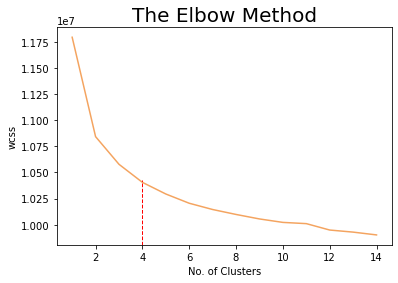

In [590]:
plt.plot(range(1, 15), wcss, color='sandybrown')
plt.title('The Elbow Method', fontsize = 20) 
plt.xlabel('No. of Clusters') 
plt.ylabel('wcss')
plt.axvline(x=4,linewidth=1, color='red', ymin=0, ymax=0.3, linestyle='--')
plt.show()

In [131]:
# Clustering 

nClusters = 4
kn = KMeans(n_clusters = nClusters , init ='k-means++' , max_iter = 300 , n_init =10 , random_state = 0)

y_means = kn.fit_predict(matrix)
y_means

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [132]:
kMeansClusterer = KMeansClusterer(nClusters, distance = cosine_distance)

clusters = kMeansClusterer.cluster(matrix, assign_clusters=True)
users_clusters=dict(zip(completeMatrix.index, clusters))

In [133]:
users_per_cluster = []

for i in range(nClusters):
    users_per_cluster.append(len([x for x in users_clusters.values() if x ==i]))
    print(f'Cluster {i+1}: {users_per_cluster[i]} utenti')

Cluster 1: 770 utenti
Cluster 2: 1197 utenti
Cluster 3: 1002 utenti
Cluster 4: 1031 utenti


In [134]:
silhouette_avg = silhouette_score(matrix, clusters)
silhouette_avg

-0.030195378351821987

## 1.5 Creazione lista di items da consigliare a ciascun utente

In [ ]:
# Creazione lista di items da consigliare a ciascun utente

reversedMatrix = completeMatrix    #matrice completa senza i rating reali per non suggerire gli items già votati
for x in reversedMatrix.index:
    for y in reversedMatrix.columns:
        if incompleteMatrix.loc[x,y]!=0.0:
            reversedMatrix.loc[x,y]=0.0

In [557]:
def recommender(user_name, n=5, details = False):
    if not details:
        suggested_items = list(reversedMatrix.loc[user_name].sort_values(ascending=False)[:n].index)
    else:
        suggested_items = pd.DataFrame(reversedMatrix.loc[user_name].sort_values(ascending=False)[:n])
    return(suggested_items)

In [28]:
print(recommender('d0ggnate'))                # you can either type just the user for a list of 5 recommendations
print(recommender('d0ggnate', 3, True))       # or manually set n° of recommendations and detail True

['Cantillon Blåbær Lambik', 'Pliny The Elder', 'Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)', 'Citra DIPA', 'Veritas 004']
                                                d0ggnate
item_name                                               
Cantillon Blåbær Lambik                             4.46
Pliny The Elder                                     4.45
Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)      4.41


In [ ]:
suggestions = {}
for user in uniqueUs:
    suggestions[user] = recommender(user, 5)

## 1.6 Matrix factorization, ricerca iperparametri ottimali e filling matrice

In [ ]:
# Matrix factorization, ricerca iperparametri ottimali e filling matrice

gridsetterSVD= Dataset.load_from_df(smallDf.sample(frac=0.2)[['user_name', 'item_name', 'rating']], reader)

param_grid_SVD = {'n_factors': [5, 10, 20],'n_epochs': [20, 30, 40],
                  'lr_all': [0.003, 0.005, 0.007],'reg_all': [0.06, 0.07, 0.08]}


gsSVD = GridSearchCV(SVD, param_grid_SVD, measures=['rmse', 'mse'], cv=5, n_jobs=-1)   
gsSVD.fit(gridsetterSVD)

In [503]:
print(f'Best RMSE = {gsSVD.best_score["rmse"]:.4f}')
print(f'Best MSE = {gsSVD.best_score["mse"]:.4f}')
print(f'Best MSE configuration = {gsSVD.best_params["mse"]}')

Best RMSE = 0.6258
Best MSE = 0.3916
Best MSE configuration = {'n_factors': 5, 'n_epochs': 40, 'lr_all': 0.003, 'reg_all': 0.08}


In [ ]:
# Fit algoritmo con iperparametri ottimali

algoSVD = SVD(n_factors = gsSVD.best_params['rmse']['n_factors'], 
              n_epochs = gsSVD.best_params['rmse']['n_epochs'],
              lr_all = gsSVD.best_params['rmse']['lr_all'],
              reg_all = gsSVD.best_params['rmse']['reg_all'],
              verbose=True)

trainset = Dataset.load_from_df(smallDf[['user_name', 'item_name', 'rating']], reader)

In [ ]:
# Metriche di errore cross validate

cross_validationSVD = cross_validate(algoSVD, trainset, measures=["RMSE","MSE"], cv=5, verbose=True) 

In [505]:
data = {'fold 1': [cross_validationSVD['test_mse'][0], cross_validationSVD['test_rmse'][0]],
        'fold 2': [cross_validationSVD['test_mse'][1], cross_validationSVD['test_rmse'][1]],
        'fold 3': [cross_validationSVD['test_mse'][2], cross_validationSVD['test_rmse'][2]],
        'fold 4': [cross_validationSVD['test_mse'][3], cross_validationSVD['test_rmse'][3]],
        'fold 5': [cross_validationSVD['test_mse'][4], cross_validationSVD['test_rmse'][4]],
        'mean': [np.mean(cross_validationSVD['test_rmse']), 
                 np.mean(cross_validationSVD['test_mse'])]}
df = pd.DataFrame(data, index=['MSE', 'RMSE'])
print(df)

        fold 1    fold 2    fold 3    fold 4    fold 5      mean
MSE   0.378971  0.381560  0.378956  0.378243  0.379704  0.616024
RMSE  0.615607  0.617706  0.615594  0.615014  0.616201  0.379487


In [ ]:
# Applichiamo l'algoritmo al dataset completo

trainset = trainset.build_full_trainset()
algoSVD.fit(trainset)

In [ ]:
completeMatrixSVD = smallDf.pivot(index='user_name', columns='item_name', values='rating').fillna(0)

for rig in completeMatrixSVD.index:
    for col in completeMatrixSVD.columns:
        if completeMatrixSVD.loc[rig,col] == 0.0:
            completeMatrixSVD.loc[rig,col] = round(algoSVD.predict(rig, col).est, 2)   

In [507]:
completeMatrixSVD.iloc[x:x+5,y:y+5]

item_name,Cocoa Porter Winter Warmer,Coffee Bender,Coffee Porter,Coffee Stout,Coffee Stout (Brewmaster Series)
user_name,,,,,
morebeergood,2.83,3.74,3.00,3.52,3.00
morimech,2.98,3.00,3.51,3.68,4.00
mortarit,2.71,3.63,4.00,3.41,3.43
mostpoetsdo,3.06,3.96,3.58,3.75,3.77
mothman,2.79,4.00,3.31,4.00,3.50


In [30]:
print(f'Cross validated RMSE obtained with KNN algorithm = {cross_validation["test_rmse"].mean()}')
print(f'Cross validated RMSE obtained with SVD algorithm = {cross_validationSVD["test_rmse"].mean()}')
print('---------------------------------------------------------------------')
print(f'Cross validated MSE obtained with KNN algorithm = {cross_validation["test_mse"].mean()}')
print(f'Cross validated MSE obtained with SVD algorithm = {cross_validationSVD["test_mse"].mean()}')

Cross validated RMSE obtained with KNN algorithm = 0.6348880782371433
Cross validated RMSE obtained with SVD algorithm = 0.6160242070225597
---------------------------------------------------------------------
Cross validated MSE obtained with KNN algorithm = 0.4030835230537315
Cross validated MSE obtained with SVD algorithm = 0.3794866713224371


In [ ]:
# Creazione lista di items da consigliare a ciascun utente (secondo SVD)

reversedMatrixSVD = completeMatrixSVD    
for x in reversedMatrixSVD.index:
    for y in reversedMatrixSVD.columns:
        if incompleteMatrix.loc[x,y]!=0.0:
            reversedMatrixSVD.loc[x,y]=0.0

In [558]:
def recommenderSVD(user_name, n=5, details = False):
    if not details:
        suggested_items = list(reversedMatrixSVD.loc[user_name].sort_values(ascending=False)[:n].index)
    else:
        suggested_items = pd.DataFrame(reversedMatrixSVD.loc[user_name].sort_values(ascending=False)[:n])
    return(suggested_items)

In [ ]:
suggestionsSVD = {}
for user in uniqueUs:
    suggestionsSVD[user] = recommenderSVD(user, 10)

In [587]:
# Esempio sulle differenti raccomandazioni

print(f'''KNN recommender: 
{recommender('AgentMunky', 10, True)}''')
print(f'''
SVD recommender: 
{recommenderSVD('AgentMunky', 10, True)}''')
print('----------------------------')
print(f'''KNN recommender: 
{recommender('sarahspat', 10, True)}''')
print(f'''
SVD recommender: 
{recommenderSVD('sarahspat', 10, True)}''')

KNN recommender: 
                                                AgentMunky
item_name                                                 
Cantillon Blåbær Lambik                               4.46
Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)        4.41
Veritas 004                                           4.39
Pliny The Younger                                     4.39
Live Oak HefeWeizen                                   4.38
Deviation - Bottleworks 9th Anniversary               4.38
Kaggen! Stormaktsporter                               4.38
Founders CBS Imperial Stout                           4.36
Heady Topper                                          4.36
Citra DIPA                                            4.36

SVD recommender: 
                                                AgentMunky
item_name                                                 
Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue)        4.45
Cantillon Blåbær Lambik                               4.43
Veritas 004        